In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from scipy.optimize import minimize
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False


In [2]:
betas=np.array([-0.3,0.3,0.7,1,1.5,2.5]).reshape(-1,1)
sigmas_e=np.array([0.15,0.16,0.1,0.11,0.12,0.14]).reshape(-1,1)
variance_e=sigmas_e*sigmas_e
r=0.02
sigma_m=0.2
variance_m=sigma_m*sigma_m
mu_m=0.08
N=6

# Exercise 1

1.a

In [3]:
mus=r+betas*(mu_m-r)
mus

array([[0.002],
       [0.038],
       [0.062],
       [0.08 ],
       [0.11 ],
       [0.17 ]])

1.b

In [4]:
covariance=np.diag((variance_e).ravel())+betas@betas.T*variance_m
covariance

array([[ 0.0261, -0.0036, -0.0084, -0.012 , -0.018 , -0.03  ],
       [-0.0036,  0.0292,  0.0084,  0.012 ,  0.018 ,  0.03  ],
       [-0.0084,  0.0084,  0.0296,  0.028 ,  0.042 ,  0.07  ],
       [-0.012 ,  0.012 ,  0.028 ,  0.0521,  0.06  ,  0.1   ],
       [-0.018 ,  0.018 ,  0.042 ,  0.06  ,  0.1044,  0.15  ],
       [-0.03  ,  0.03  ,  0.07  ,  0.1   ,  0.15  ,  0.2696]])

1.c

In [5]:
volatilities=np.sqrt(np.diag(covariance)).reshape(-1,1)
volatilities

array([[0.16155494],
       [0.17088007],
       [0.17204651],
       [0.22825424],
       [0.32310989],
       [0.5192302 ]])

In [6]:
correlation=covariance/(volatilities@volatilities.T)
correlation

array([[ 1.        , -0.13040397, -0.30221302, -0.32541842, -0.34482759,
        -0.35763586],
       [-0.13040397,  1.        ,  0.2857209 ,  0.30765995,  0.32600993,
         0.33811924],
       [-0.30221302,  0.2857209 ,  1.        ,  0.71300621,  0.75553256,
         0.78359605],
       [-0.32541842,  0.30765995,  0.71300621,  1.        ,  0.81354605,
         0.84376439],
       [-0.34482759,  0.32600993,  0.75553256,  0.81354605,  1.        ,
         0.89408965],
       [-0.35763586,  0.33811924,  0.78359605,  0.84376439,  0.89408965,
         1.        ]])

1.d

In [7]:
sharpe_ratios=(mus-r)/np.sqrt(np.diag(covariance)).reshape(-1,1)
sharpe_ratios

array([[-0.1114172 ],
       [ 0.10533703],
       [ 0.24412004],
       [ 0.26286477],
       [ 0.27854301],
       [ 0.28888921]])

# Exercise 2


2.a

We consider the following Quadratic Programming (QP) problem:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$

subject to:

$$
Ax = B
$$

$$
Cx \leq D
$$


where: 


$$
Q = \Sigma
$$

$$
R = \gamma*(\mu - r)
$$

$$
A = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 1 \end{bmatrix}
$$

$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
10 \\10 \\ 10 \\ 10 \\ 10 \\ 10 \\ 
10 \\ 10 \\ 10 \\ 10 \\ 10 \\ 10 
\end{bmatrix}
$$


2.b

In [8]:
def Gamma_Solver(returns, covariance, gamma, r):
    N = returns.shape[0]    
    Q = matrix(covariance,tc='d')
    R = matrix(-gamma * (returns - r),tc='d')  
    
    A = matrix(np.ones((1, N)),tc='d')
    B = matrix(1.0)
    
    C = matrix(np.vstack((-np.eye(N), np.eye(N))),tc='d')  
    D = matrix(np.full((N*2,1),10),tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    
    mu = float(portfolio.T @ returns) 
    var = float(portfolio.T @ covariance @ portfolio) 
    vol = np.sqrt(var)  
    sharpe_ratio = (mu - r) / vol
    
    return portfolio, mu, vol, sharpe_ratio


gammas=[0,0.1,0.2,0.5,1]

gamma_portfolios=[]
gamma_returns=[]
gamma_volatilities=[]
gamma_sharpe_ratios=[]

for gamma in gammas:
    results=Gamma_Solver(mus,covariance,gamma,r)
    gamma_portfolios.append(results[0])
    gamma_returns.append(results[1])
    gamma_volatilities.append(results[2])
    gamma_sharpe_ratios.append(results[3])
    
    print(f"Gamma: {gamma:.2f}")
    print(f"  Portfolio Weights :\n {results[0]}")
    print(f"  Expected Return: {results[1]:.4f}")
    print(f"  Volatility: {results[2]:.4f}")
    print(f"  Sharpe Ratio: {results[3]:.4f}")
    print("-" * 50)

Gamma: 0.00
  Portfolio Weights :
 [[ 0.33295234]
 [ 0.20351853]
 [ 0.36891721]
 [ 0.21061947]
 [ 0.0449561 ]
 [-0.16096365]]
  Expected Return: 0.0257
  Volatility: 0.0797
  Sharpe Ratio: 0.0716
--------------------------------------------------
Gamma: 0.10
  Portfolio Weights :
 [[ 0.2999226 ]
 [ 0.1879909 ]
 [ 0.3522106 ]
 [ 0.2110959 ]
 [ 0.06536001]
 [-0.11658001]]
  Expected Return: 0.0338
  Volatility: 0.0846
  Sharpe Ratio: 0.1635
--------------------------------------------------
Gamma: 0.20
  Portfolio Weights :
 [[ 0.26689285]
 [ 0.17246327]
 [ 0.33550398]
 [ 0.21157233]
 [ 0.08576393]
 [-0.07219636]]
  Expected Return: 0.0420
  Volatility: 0.0980
  Sharpe Ratio: 0.2242
--------------------------------------------------
Gamma: 0.50
  Portfolio Weights :
 [[0.16780362]
 [0.12588037]
 [0.28538415]
 [0.21300161]
 [0.14697567]
 [0.06095458]]
  Expected Return: 0.0664
  Volatility: 0.1634
  Sharpe Ratio: 0.2839
--------------------------------------------------
Gamma: 1.00
  Port

2c

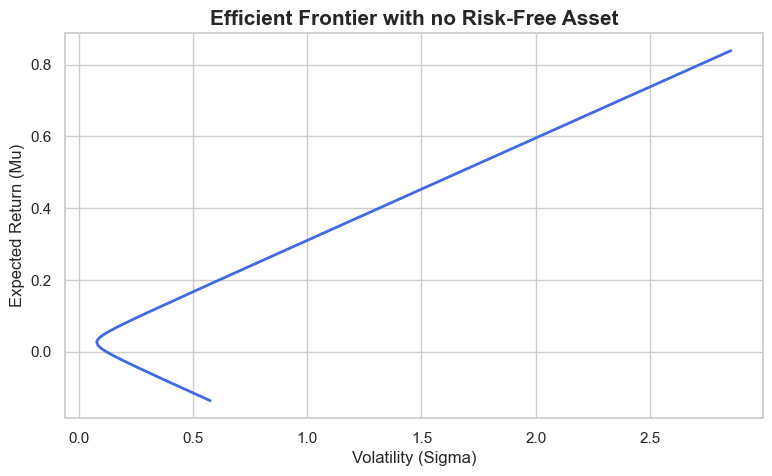

In [9]:
gammas1 = np.arange(-2, 0, 0.1)
gammas2 = np.arange(0,1.05,0.05)
gammas3 = np.arange(2,11,1)

gammas=np.concatenate([gammas1,gammas2,gammas3])
gamma_returns_NoRiskFree=[]
gamma_volatilities_NoRiskFree=[]

for gamma in gammas:
    results=Gamma_Solver(mus,covariance,gamma,r)
    gamma_returns_NoRiskFree.append(results[1])
    gamma_volatilities_NoRiskFree.append(results[2])

sns.set_theme(style="whitegrid")  
plt.figure(figsize=(9, 5))
plt.plot(gamma_volatilities_NoRiskFree, gamma_returns_NoRiskFree, color='royalblue', linewidth=2, label="Efficient Frontier", linestyle='-')
plt.title("Efficient Frontier with no Risk-Free Asset", fontsize=15, fontweight='bold')
plt.xlabel("Volatility (Sigma)", fontsize=12)
plt.ylabel("Expected Return (Mu)", fontsize=12)
plt.show()



2d

In [10]:
TargetVol=0.10
gamma0=-0.5
gamma1=10

while(gamma1-gamma0>1e-11):
    _, _, sigmanew,_ = Gamma_Solver(mus, covariance,(gamma1+gamma0)/2,r)
    if(sigmanew<TargetVol):
        gamma0 = (gamma1+gamma0)/2
    else:
        gamma1 =(gamma1+gamma0)/2

gammafinal=(gamma1+gamma0)/2

portfolio, mu, sigma, sharpe_ratio = Gamma_Solver(mus, covariance, gammafinal, r)

print(f"Target Volatility: 10%")
print()
print(f"Portfolio:\n{portfolio}")
print(f"Gamma: {gammafinal:.2f}")
print(f"Expected Return: {mu:.4f}")
print(f"Volatility: {sigma:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print()


TargetVol=0.15
gamma0=-0.5
gamma1=10


while(gamma1-gamma0>1e-11):
    _, _, sigmanew,_ = Gamma_Solver(mus, covariance,(gamma1+gamma0)/2,r)
    if(sigmanew<TargetVol):
        gamma0 = (gamma1+gamma0)/2
    else:
        gamma1 =(gamma1+gamma0)/2

gammafinal=(gamma1+gamma0)/2

portfolio, mu, sigma, sharpe_ratio = Gamma_Solver(mus, covariance, gammafinal, r)

print(f"Target Volatility: 15%")
print()
print(f"Portfolio:\n{portfolio}")
print(f"Gamma: {gammafinal:.2f}")
print(f"Expected Return: {mu:.4f}")
print(f"Volatility: {sigma:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Target Volatility: 10%

Portfolio:
[[ 0.26299946]
 [ 0.17063294]
 [ 0.33353469]
 [ 0.21162848]
 [ 0.08816905]
 [-0.06696462]]
Gamma: 0.21
Expected Return: 0.0429
Volatility: 0.1000
Sharpe Ratio: 0.2293

Target Volatility: 15%

Portfolio:
[[0.18579564]
 [0.13433861]
 [0.2944846 ]
 [0.21274209]
 [0.13586121]
 [0.03677784]]
Gamma: 0.45
Expected Return: 0.0620
Volatility: 0.1500
Sharpe Ratio: 0.2797


2e

In [11]:
inv_cov=np.linalg.inv(covariance)
tangency_portfolio=((inv_cov@(mus-r))/(np.ones(6).reshape(1,-1)@inv_cov@(mus-r)))
exp_ret_tangency_portfolio=(tangency_portfolio.T@mus)[0][0]
vol_tangency_portfolio=np.sqrt(tangency_portfolio.T@covariance@tangency_portfolio)[0][0]
sharpe_ratio_tangency_portfolio=(exp_ret_tangency_portfolio-r)/vol_tangency_portfolio
print()
print("=" * 50)
print("Tangency Portfolio Results")
print("=" * 50)
print(f"Portfolio Weights: {tangency_portfolio.flatten()}")
print(f"Expected Return: {exp_ret_tangency_portfolio:.4f}")
print(f"Volatility: {vol_tangency_portfolio:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_tangency_portfolio:.4f}")
print("=" * 50)



Tangency Portfolio Results
Portfolio Weights: [-0.03483583  0.03061743  0.18288809  0.21592454  0.27215489  0.33325089]
Expected Return: 0.1163
Volatility: 0.3275
Sharpe Ratio: 0.2941


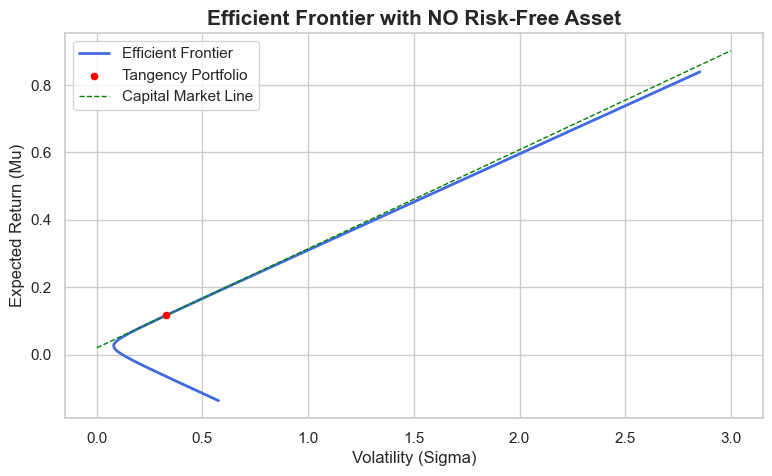

In [12]:
plt.figure(figsize=(9, 5))

vol_CML = np.linspace(0, 3, 100)  
slope_CML = (exp_ret_tangency_portfolio - r) / vol_tangency_portfolio
ret_CML = r + slope_CML * vol_CML 

sns.set_theme(style="whitegrid")  

plt.plot(gamma_volatilities_NoRiskFree, gamma_returns_NoRiskFree, color='royalblue', 
         linewidth=2, linestyle='-', label="Efficient Frontier")

plt.scatter(vol_tangency_portfolio, exp_ret_tangency_portfolio, color='red', s=20, zorder=3, label="Tangency Portfolio")

plt.plot(vol_CML, ret_CML, color='green', linewidth=1, linestyle='--', label="Capital Market Line")


plt.title("Efficient Frontier with NO Risk-Free Asset", fontsize=15, fontweight='bold')
plt.xlabel("Volatility (Sigma)", fontsize=12)
plt.ylabel("Expected Return (Mu)", fontsize=12)

plt.legend()

plt.show()



2f

In [13]:
max_sr=-1000
for gamma in np.arange(0, 5, 0.001):  
    _,_,_,sharpe_ratio=Gamma_Solver(mus,covariance,gamma,r)    
    if(sharpe_ratio>max_sr):
        max_sr=sharpe_ratio
        gamma_true=gamma
        
       
for gamma_new in np.arange(gamma_true-0.002,gamma_true+0.00001,0.00001):
    _,_,_,sharpe_ratio=Gamma_Solver(mus,covariance,gamma_new,r)
    if(sharpe_ratio>max_sr):
        max_sr=sharpe_ratio
        gamma_truee=gamma_new


        
print()
print("=" * 50)
print()
print("Gamma of the Tanjency Portfolio")
print(gamma_truee)
print()
 
portfolio,mu,vol,sharpe_ratio = Gamma_Solver(mus,covariance,gamma_truee,r)

print("=" * 50)
print("Numerical Tangency Portfolio Results")
print("=" * 50)
print(f"Portfolio Weights: {portfolio.flatten()}")
print(f"Expected Return: {mu:.5f}")
print(f"Volatility: {vol:.5f}")
print(f"Sharpe Ratio: {sharpe_ratio:.5f}")
print("=" * 50)



Gamma of the Tanjency Portfolio
1.11351000000001

Numerical Tangency Portfolio Results
Portfolio Weights: [-0.03483717  0.03061679  0.1828874   0.21592456  0.27215572  0.33325269]
Expected Return: 0.11630
Volatility: 0.32746
Sharpe Ratio: 0.29408


2g

To extend the problem introducing the risk free asset we can simply change the covariance matrix and the return vectors including the risk free asset.

We consider the following Quadratic Programming (QP) problem, including the risk-free asset:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$

subject to:

$$
Ax = B
$$

$$
Cx \leq D
$$



where:

$$
Q = \Sigma_{\text{extended}} 
$$

$$
R = \gamma * (\mu_{\text{extended}} - r_f)
$$

The **risk-free asset** is incorporated by extending the constraints:

$$
A = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 1 \end{bmatrix}
$$

$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 
1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 
\end{bmatrix}
$$


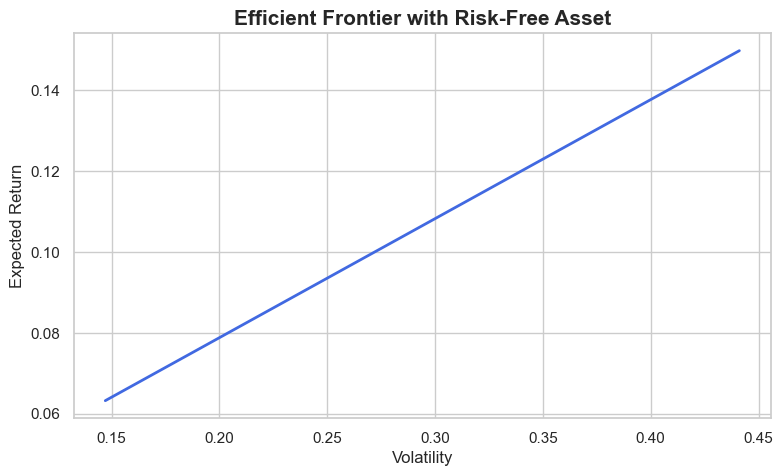

In [14]:
mus_new=np.vstack((mus,np.array([[r]])))
covariance_new = np.zeros((N+1, N+1)) 
covariance_new[:N, :N] = covariance  

gammas=np.arange(0.5,1.51,0.01)

gamma_portfolios_RiskFree=[]
gamma_returns_RiskFree=[]
gamma_volatilities_RiskFree=[]
gamma_sharpe_ratios_RiskFree=[]


for gamma in gammas:
    results=Gamma_Solver(mus_new,covariance_new,gamma,r)
    gamma_returns_RiskFree.append(results[1])
    gamma_volatilities_RiskFree.append(results[2])
    gamma_sharpe_ratios_RiskFree.append(results[3])

sns.set_theme(style="whitegrid")  
plt.figure(figsize=(9, 5))


plt.plot(gamma_volatilities_RiskFree, gamma_returns_RiskFree, color='royalblue', linewidth=2, label="Efficient Frontier", linestyle='-')
plt.title("Efficient Frontier with Risk-Free Asset", fontsize=15, fontweight='bold')
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.show()

We observe that all the sharpe_ratios corresponding to positive gammas are equal, this is because the efficient frontier is given by two straight lines, which coincide with the capital market line for positive gamma.

To find the tangency portfolio we can search for the first portfolio which as near zero allocation in the risk-free asset

In [15]:
for gamma in np.arange(0, 5, 0.001):  
    results = Gamma_Solver(mus_new, covariance_new, gamma, r)
    
    if results[0][-1] < 0:  
        break
for gamma_new in np.arange(gamma-0.002,gamma+0.00001,0.00001):
    results = Gamma_Solver(mus_new, covariance_new, gamma_new, r)
    if results[0][-1] < 0:  
        break

vol_tangency_portfolio_brute_force=results[2]
exp_ret_tangency_portfolio_brute_force=results[1]
print("Portfolio:\n")
print(results[0])
print("Gamma:\n")
print (gamma_new)
print("Expected Return:\n")
print(exp_ret_tangency_portfolio_brute_force)
print("volatility\n")
print(vol_tangency_portfolio_brute_force)
print("Sharpe Ratio:\n")
print(results[3])


Portfolio:

[[-3.48359544e-02]
 [ 3.06175368e-02]
 [ 1.82888749e-01]
 [ 2.15925326e-01]
 [ 2.72155883e-01]
 [ 3.33252105e-01]
 [-3.64533933e-06]]
Gamma:

1.11351000000001
Expected Return:

0.11629685511115333
volatility

0.32745612066120594
Sharpe Ratio:

0.2940755998596355


We can verify that the one above is indeed the same tangency portfoli as the previous one (except for a small error)


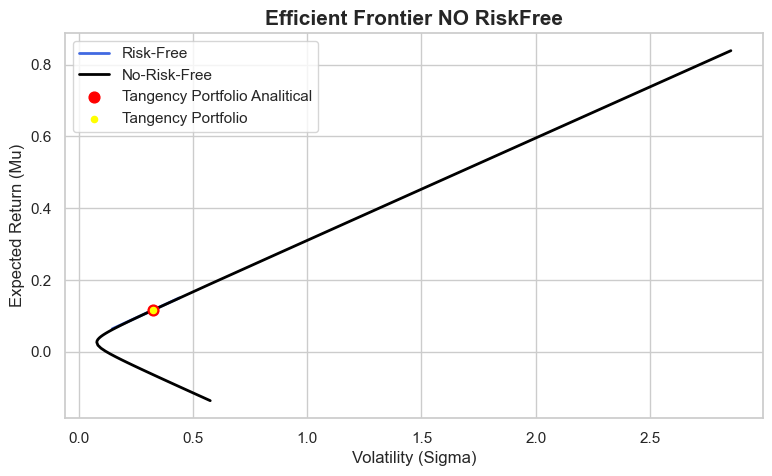

In [16]:
plt.figure(figsize=(9, 5))

vol_CML = np.linspace(0, 3, 100)  
slope_CML = (exp_ret_tangency_portfolio - r) / vol_tangency_portfolio
ret_CML = r + slope_CML * vol_CML 

plt.plot(gamma_volatilities_RiskFree, gamma_returns_RiskFree, color='royalblue', 
         linewidth=2, linestyle='-', label="Risk-Free")


plt.plot(gamma_volatilities_NoRiskFree, gamma_returns_NoRiskFree, color='black', 
         linewidth=2, linestyle='-', label="No-Risk-Free")


plt.scatter(vol_tangency_portfolio, exp_ret_tangency_portfolio, color='red', s=60, zorder=3, label="Tangency Portfolio Analitical")

plt.scatter(vol_tangency_portfolio_brute_force, exp_ret_tangency_portfolio_brute_force, color='yellow', s=20, zorder=3, label="Tangency Portfolio ")




plt.title("Efficient Frontier NO RiskFree", fontsize=15, fontweight='bold')
plt.xlabel("Volatility (Sigma)", fontsize=12)
plt.ylabel("Expected Return (Mu)", fontsize=12)

plt.legend()

plt.show()

2h See the report

# Exercise 3

3a

We go back to no risk free asset but we change the constraints to ensure long only investments


We consider the following **Quadratic Programming (QP)** problem:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$

subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

where:


$$
Q = \Sigma
$$

$$
R = \gamma*(\mu - r)
$$

$$
A = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 1 \end{bmatrix}
$$

$$
C = \begin{bmatrix} 
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
-1 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 
\end{bmatrix}
$$


In [17]:
print("Portfolios mean volatility and sharpe ratio for various gammas")

def Gamma_Solver_LongOnly(returns, covariance, gamma, r):
    N = returns.shape[0]    
    Q = matrix(covariance, tc='d')
    R = matrix(-gamma * (returns - r), tc='d')  
    
    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')
    
    C = matrix( -np.eye(N), tc='d')  
    D = matrix( np.full(N, 0), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    mu = float(portfolio.T @ returns)  
    var = float(portfolio.T @ covariance @ portfolio)  
    vol = np.sqrt(var)  
    sharpe_ratio = (mu - r) / vol  
    
    return portfolio, mu, vol, sharpe_ratio

gammas = [0, 0.1, 0.2, 0.5, 1]

gamma_portfolios_LongOnly = []
gamma_returns_LongOnly = []
gamma_volatilities_LongOnly = []
gamma_sharpe_ratios_LongOnly = []

for gamma in gammas:
    results = Gamma_Solver_LongOnly(mus, covariance, gamma, r)
    gamma_portfolios_LongOnly.append(results[0])
    gamma_returns_LongOnly.append(results[1])
    gamma_volatilities_LongOnly.append(results[2])
    gamma_sharpe_ratios_LongOnly.append(results[3])
    
    print(f"Gamma: {gamma:.2f}")
    print(f"  Portfolio Weights :\n {results[0]}")
    print(f"  Expected Return: {results[1]:.4f}")
    print(f"  Volatility: {results[2]:.4f}")
    print(f"  Sharpe Ratio: {results[3]:.4f}")
    print("-" * 50)


Portfolios mean volatility and sharpe ratio for various gammas
Gamma: 0.00
  Portfolio Weights :
 [[4.45841251e-01]
 [2.22331926e-01]
 [2.79854161e-01]
 [5.19651922e-02]
 [6.71214885e-06]
 [7.58310308e-07]]
  Expected Return: 0.0308
  Volatility: 0.0887
  Sharpe Ratio: 0.1224
--------------------------------------------------
Gamma: 0.10
  Portfolio Weights :
 [[3.72144783e-01]
 [2.02357263e-01]
 [3.05173107e-01]
 [1.20271319e-01]
 [5.19256177e-05]
 [1.60108379e-06]]
  Expected Return: 0.0370
  Volatility: 0.0921
  Sharpe Ratio: 0.1845
--------------------------------------------------
Gamma: 0.20
  Portfolio Weights :
 [[3.04178669e-01]
 [1.81936956e-01]
 [3.19996336e-01]
 [1.74111273e-01]
 [1.97766920e-02]
 [7.40694324e-08]]
  Expected Return: 0.0435
  Volatility: 0.1022
  Sharpe Ratio: 0.2296
--------------------------------------------------
Gamma: 0.50
  Portfolio Weights :
 [[0.16781049]
 [0.12588297]
 [0.28538092]
 [0.212994  ]
 [0.14696351]
 [0.0609681 ]]
  Expected Return: 0.0

3b

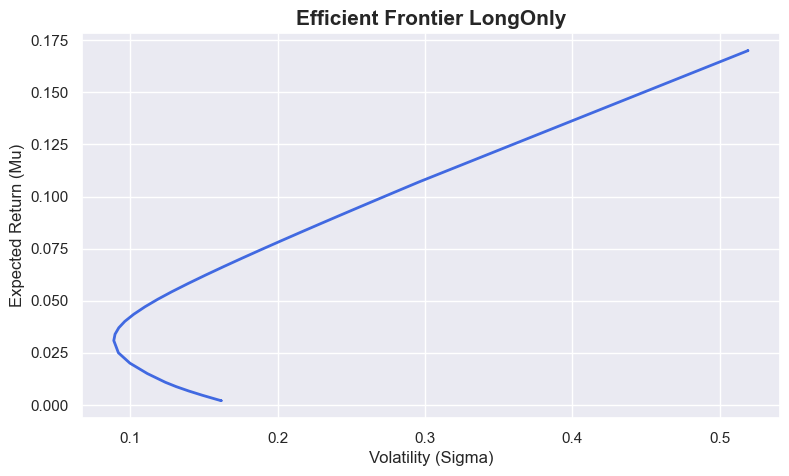

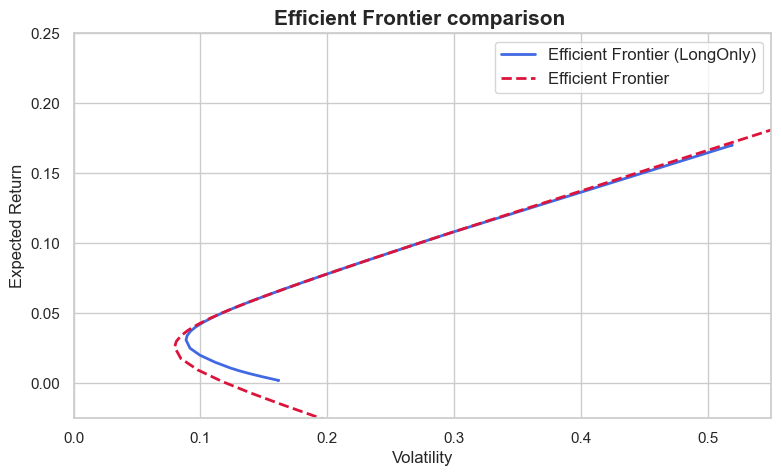

In [18]:
gammas1 = np.arange(-2, 0, 0.1)
gammas2 = np.arange(0,1.05,0.05)
gammas3 = np.arange(2,11,1)
gammas=np.concatenate([gammas1,gammas2,gammas3])

gamma_portfolios_LongOnly=[]
gamma_returns_LongOnly=[]
gamma_volatilities_LongOnly=[]
gamma_sharpe_ratios_LongOnly=[]


for gamma in gammas:
    results=Gamma_Solver_LongOnly(mus,covariance,gamma,r)
    gamma_portfolios_LongOnly.append(results[0])
    gamma_returns_LongOnly.append(results[1])
    gamma_volatilities_LongOnly.append(results[2])
    gamma_sharpe_ratios_LongOnly.append(results[3])



sns.set_theme(style="darkgrid")  
plt.figure(figsize=(9, 5))
plt.plot(gamma_volatilities_LongOnly, gamma_returns_LongOnly, color='royalblue', linewidth=2, label="Efficient Frontier", linestyle='-')
plt.title("Efficient Frontier LongOnly", fontsize=15, fontweight='bold')
plt.xlabel("Volatility (Sigma)", fontsize=12)
plt.ylabel("Expected Return (Mu)", fontsize=12)
plt.show()



sns.set_theme(style="whitegrid")

plt.figure(figsize=(9, 5))

plt.plot(gamma_volatilities_LongOnly, gamma_returns_LongOnly, 
         color='royalblue', linewidth=2, linestyle='-', label="Efficient Frontier (LongOnly)")

plt.plot(gamma_volatilities_NoRiskFree, gamma_returns_NoRiskFree, 
         color='crimson', linewidth=2, linestyle='--', label="Efficient Frontier")

plt.title("Efficient Frontier comparison ", fontsize=15, fontweight='bold')
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)

plt.legend(fontsize=12)
plt.xlim(0, 0.55)
plt.ylim(-0.025, 0.25)

plt.show()



As expected, introducing constraints to the mean-variance optimizer results in an efficient frontier that is strictly dominated, in terms of mean-variance optimization, by the originalfrontier.

However, we observe that for sufficiently high and positive values of gamma, the two frontiers nearly overlap.

3c

In [37]:
print()
print("3c")
TargetVol=0.10
gamma0=-0.5
gamma1=10

while(gamma1-gamma0>1e-11):
    _, _, sigmanew,_ = Gamma_Solver_LongOnly(mus, covariance,(gamma1+gamma0)/2,r)
    if(sigmanew<TargetVol):
        gamma0 = (gamma1+gamma0)/2
    else:
        gamma1 =(gamma1+gamma0)/2

gammafinal=(gamma1+gamma0)/2

portfolio, mu, sigma, sharpe_ratio = Gamma_Solver_LongOnly(mus, covariance, gammafinal, r)

print(f"Target Volatility: 10%")
print(f"Gamma: {gammafinal:.2f}")
print("Portfolio:")
print(portfolio)
print()
print(f"Expected Return: {mu:.4f}")
print(f"Volatility: {sigma:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

print()


TargetVol=0.15
gamma0=-0.5
gamma1=10


while(gamma1-gamma0>1e-11):
    _, _, sigmanew,_ = Gamma_Solver_LongOnly(mus, covariance,(gamma1+gamma0)/2,r)
    if(sigmanew<TargetVol):
        gamma0 = (gamma1+gamma0)/2
    else:
        gamma1 =(gamma1+gamma0)/2

gammafinal=(gamma1+gamma0)/2

portfolio, mu, sigma, sharpe_ratio = Gamma_Solver_LongOnly(mus, covariance, gammafinal, r)

print(f"Target Volatility: 15%")
print(f"Gamma: {gammafinal:.2f}")
print("Portfolio:")
print(portfolio)
print()
print(f"Expected Return: {mu:.4f}")
print(f"Volatility: {sigma:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


3c
Target Volatility: 10%
Gamma: 0.18
Portfolio:
[[3.13156344e-01]
 [1.85358104e-01]
 [3.21126692e-01]
 [1.70317514e-01]
 [1.00412765e-02]
 [6.94757234e-08]]

Expected Return: 0.0423
Volatility: 0.1000
Sharpe Ratio: 0.2231

Target Volatility: 15%
Gamma: 0.45
Portfolio:
[[0.18579658]
 [0.13433889]
 [0.29448433]
 [0.21274127]
 [0.1358597 ]
 [0.03677923]]

Expected Return: 0.0620
Volatility: 0.1500
Sharpe Ratio: 0.2797


3d

In [20]:
gammas=np.arange(0,4,0.001)
max_sr=-1000
for gamma in gammas:
    _,_,_,sharpe_ratio=Gamma_Solver_LongOnly(mus,covariance,gamma,r)
    if(sharpe_ratio>max_sr):
        max_sr=sharpe_ratio
        gamma_true=gamma
gamma_long_only=gamma_true

print("Gamma of the Tanjency Portfolio")
print(gamma_true)

tangency_portfolio_Long_Only,mu_tangency_portfolio_Long_Only,vol_tangency_portfolio_Long_Only,sharpe_ratio_tangency_portfolio_Long_Only = Gamma_Solver_LongOnly(mus,covariance,gamma_true,r)

print("=" * 50)
print("Numerical Tangency Portfolio Long_Only")
print("=" * 50)
print(f"Portfolio Weights: {tangency_portfolio_Long_Only.flatten()}")
print(f"Expected Return: {mu_tangency_portfolio_Long_Only:.4f}")
print(f"Volatility: {vol_tangency_portfolio_Long_Only:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_tangency_portfolio_Long_Only:.4f}")
print("=" * 50)

print("Tangency Portfolio Long/Short")
print("=" * 50)
print(f"Portfolio Weights: {tangency_portfolio.flatten()}")
print(f"Expected Return: {exp_ret_tangency_portfolio:.4f}")
print(f"Volatility: {vol_tangency_portfolio:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_tangency_portfolio:.4f}")
print("=" * 50)


Gamma of the Tanjency Portfolio
1.069
Numerical Tangency Portfolio Long_Only
Portfolio Weights: [3.75020374e-06 2.96676698e-02 1.76841109e-01 2.08686393e-01
 2.62934901e-01 3.21866176e-01]
Expected Return: 0.1124
Volatility: 0.3143
Sharpe Ratio: 0.2940
Tangency Portfolio Long/Short
Portfolio Weights: [-0.03483583  0.03061743  0.18288809  0.21592454  0.27215489  0.33325089]
Expected Return: 0.1163
Volatility: 0.3275
Sharpe Ratio: 0.2941


We observe that the weights of the original tangency portfolio nearly satisfy the long-only constraints on their own, with the exception of the first asset. As a result, the long-only tangency portfolio is quite similar to the long/short one, and the Sharpe ratio remains nearly identical.

3e

In [39]:
print()
print("3e")
Covariances=covariance@tangency_portfolio_Long_Only
Long_Only_Betas=Covariances/(vol_tangency_portfolio_Long_Only*vol_tangency_portfolio_Long_Only)
print()
print("Betas")
print()
print(Long_Only_Betas)
print()
print("")
implied_expected_returns=r+Long_Only_Betas*(mu_tangency_portfolio_Long_Only-r)
print()
print("Impllied Expected Returns")
print()
print(implied_expected_returns)
print()
print("Alpha Coefficients")
print()
alphas=mus-implied_expected_returns_2

print(alphas)
print()



3e

Betas

[[-0.18708459]
 [ 0.19477209]
 [ 0.45443039]
 [ 0.64917416]
 [ 0.97374712]
 [ 1.62289304]]



Impllied Expected Returns

[[0.00270842]
 [0.03800211]
 [0.06200142]
 [0.08000091]
 [0.11000007]
 [0.16999837]]

Alpha Coefficients

[[-7.08420414e-04]
 [-2.10834991e-06]
 [-1.42312026e-06]
 [-9.14067476e-07]
 [-6.57497300e-08]
 [ 1.63084567e-06]]



# Exercise 4

In [22]:
def MR (covariance,x):
    denominator=np.sqrt(x.T@covariance@x)
    numerator = covariance@x 
    return (numerator/denominator)
def RC (covariance,x):
    return (x*MR(covariance,x))
def RRC(covariance,x):
    return (RC(covariance,x))/np.sqrt(x.T@covariance@x)
def portfolio_vol(portfolio,covariance):
    return (np.sqrt(portfolio.T@covariance@portfolio))
def portfolio_mean (portfolio,returns):
    return (portfolio.T@returns)

4a 

In [40]:
print("Long-Only Tangency Portfolio Risk Decomposition")

print("Portfolio:")
print(tangency_portfolio_Long_Only)
print()
print("MR")
print(MR(covariance,tangency_portfolio_Long_Only))
print("RC")
print(RC(covariance,tangency_portfolio_Long_Only))
print("RRC")
print(RRC(covariance,tangency_portfolio_Long_Only))



Long-Only Tangency Portfolio Risk Decomposition
Portfolio:
[[3.75020374e-06]
 [2.96676698e-02]
 [1.76841109e-01]
 [2.08686393e-01]
 [2.62934901e-01]
 [3.21866176e-01]]

MR
[[-0.05880731]
 [ 0.06122377]
 [ 0.14284356]
 [ 0.20405843]
 [ 0.3060832 ]
 [ 0.51013275]]
RC
[[-2.20539407e-07]
 [ 1.81636649e-03]
 [ 2.52606144e-02]
 [ 4.25842176e-02]
 [ 8.04799571e-02]
 [ 1.64194479e-01]]
RRC
[[-7.01605347e-07]
 [ 5.77843414e-03]
 [ 8.03619739e-02]
 [ 1.35473814e-01]
 [ 2.56032103e-01]
 [ 5.22354376e-01]]


4b

In [42]:
EW_Portfolio=np.ones(N).reshape(-1, 1)/N
print("EW Tangency Portfolio Risk Decomposition")
print()
print("Portfolio:")
print(EW_Portfolio)
print("MR")
print(MR(covariance,EW_Portfolio))
print("RC")
print(RC(covariance,EW_Portfolio))
print("RRC")
print(RRC(covariance,EW_Portfolio))
print("Volatility")
print(np.sqrt(EW_Portfolio.T@covariance@EW_Portfolio))


EW Tangency Portfolio Risk Decomposition

Portfolio:
[[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]]
MR
[[-0.03874004]
 [ 0.0793369 ]
 [ 0.14314403]
 [ 0.2026467 ]
 [ 0.30080502]
 [ 0.49762805]]
RC
[[-0.00645667]
 [ 0.01322282]
 [ 0.02385734]
 [ 0.03377445]
 [ 0.05013417]
 [ 0.08293801]]
RRC
[[-0.03269697]
 [ 0.06696111]
 [ 0.12081493]
 [ 0.17103576]
 [ 0.25388232]
 [ 0.42000285]]
Volatility
[[0.19747011]]


In [25]:
print(EW_Portfolio)

[[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]]


4c

To find the minimum variance portfolio we solve another QP Problem but without considering the return optimization

We consider the following **Quadratic Programming (QP)** problem:

$$
x^* = \arg\min \frac{1}{2} x^T Q x
$$

subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

where:

$$
A = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 1 \end{bmatrix}
$$

$$
Q = \Sigma
$$


$$
C = \begin{bmatrix} 
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
-1 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 
\end{bmatrix}
$$


In [26]:
def MinimumVariance_Solver_Long_Only(covariance):
    N = covariance.shape[0]  
    
    Q = matrix(covariance, tc='d')
    R = matrix(np.zeros(N), tc='d')  
    
    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')
    
    C = matrix(-np.eye(N), tc='d')  
    D = matrix(np.full(N, 0), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    var = float(portfolio.T @ covariance @ portfolio)  
    vol = np.sqrt(var)  

    return portfolio


In [27]:
np.ones((1, N))

array([[1., 1., 1., 1., 1., 1.]])

In [43]:
minimum_variance_portfolio=MinimumVariance_Solver_Long_Only(covariance)


print("MV Portfolio Risk Decomposition")
print("Portfolio:")
print()
print(minimum_variance_portfolio)
print()

print("MR")
print(MR(covariance,minimum_variance_portfolio))
print("RC")
print(RC(covariance,minimum_variance_portfolio))
print("RRC")
print(RRC(covariance,minimum_variance_portfolio))
print("Volatility")
print(np.sqrt(minimum_variance_portfolio.T@covariance@minimum_variance_portfolio))

MV Portfolio Risk Decomposition
Portfolio:

[[4.45841251e-01]
 [2.22331926e-01]
 [2.79854161e-01]
 [5.19651922e-02]
 [6.71214885e-06]
 [7.58310308e-07]]

MR
[[0.08866524]
 [0.08866528]
 [0.08866529]
 [0.08866647]
 [0.12236344]
 [0.20393741]]
RC
[[3.95306232e-02]
 [1.97131235e-02]
 [2.48133509e-02]
 [4.60757017e-03]
 [8.21321603e-07]
 [1.54647842e-07]]
RRC
[[4.45839240e-01]
 [2.22331026e-01]
 [2.79853051e-01]
 [5.19656767e-02]
 [9.26313247e-06]
 [1.74416872e-06]]
Volatility
[[0.08866564]]


In [29]:
def most_diversified_portfolio(covariance):
    N = covariance.shape[0]  
    
    Q = matrix(covariance, tc='d')
    R = matrix(np.zeros(N), tc='d')  
    
    A = matrix(np.sqrt(np.diag(covariance)).reshape(1, -1), tc='d')
    B = matrix(1.0, tc='d')
    
    C = matrix( -np.eye(N), tc='d')  
    D = matrix( np.zeros(N), tc='d')

    sol = solvers.qp(Q, R, C, D,  A, B)
    portfolio = np.array(sol['x'])  

    portfolio=portfolio/np.sum(portfolio)

    return portfolio

4d

In [44]:
MDP_portfolio = most_diversified_portfolio(covariance).reshape(-1,1)


print("Most Diversified Portfolio:")
print(MDP_portfolio)
print()
print("MR")
print(MR(covariance,MDP_portfolio))
print("RC")
print(RC(covariance,MDP_portfolio))
print("RRC")
print(RRC(covariance,MDP_portfolio))
print("Volatility")
print(np.sqrt(MDP_portfolio.T@covariance@MDP_portfolio))

Most Diversified Portfolio:
[[0.47995619]
 [0.20740348]
 [0.14051526]
 [0.09571026]
 [0.05578608]
 [0.02062873]]

MR
[[0.08207653]
 [0.08681408]
 [0.08740667]
 [0.1159625 ]
 [0.16415307]
 [0.2637902 ]]
RC
[[0.03939314]
 [0.01800554]
 [0.01228197]
 [0.0110988 ]
 [0.00915746]
 [0.00544166]]
RRC
[[0.41301878]
 [0.18877974]
 [0.12877076]
 [0.11636578]
 [0.09601169]
 [0.05705325]]
Volatility
[[0.09537856]]


4e
Here i implemented all the main ways to compute the ERC portfolio seen in class, we notice that the solition found by the jacobi method is not long only.

From now on we will work with the solution found by the CCD algorithm

In [31]:
print("4e")
print("ERC PORTFOLIO")
print("CCD way ===============================")
def ERC_CCD(covariance,lambdac):
    N=covariance.shape[0]
    y_prev=np.ones(N).reshape(-1,1)
    y_new=np.zeros(N).reshape(-1,1)
    a=np.ones(N).reshape(-1,1)/N
    b=np.ones(N).reshape(-1,1)/N
    gamma=np.zeros(N).reshape(-1,1)
    
    error=1
    while(error>1e-6):
        for i in range(N):
            a[i]=covariance[i][i]
            b[i]=(y_new[:i].T@covariance[i][:i]+y_prev[i+1:].T@covariance[i][i+1:])
            gamma[i]=-lambdac
            y_new[i]=(-b[i]+np.sqrt(b[i]*b[i]-4*a[i]*gamma[i]))/(2*a[i])
        error=np.linalg.norm(RRC(covariance,y_new)-np.ones(N).reshape(-1,1)/N,np.inf)
        y_prev=y_new
    portfolio=y_new/np.sum(y_new)
    return portfolio

ERC_Portfolio_CCD=ERC_CCD(covariance,1)
print(ERC_Portfolio_CCD)



print("ERC_Portfolio_CCD  Risk Decomposition CCD")
print("MR")
print(MR(covariance,ERC_Portfolio_CCD))
print("RC")
print(RC(covariance,ERC_Portfolio_CCD))
print("RRC")
print(RRC(covariance,ERC_Portfolio_CCD))
print("Volatility")
print(np.sqrt(ERC_Portfolio_CCD.T@covariance@ERC_Portfolio_CCD))

print()
print("Jacobi way ===============================")
print()
def Beta(covariance,x):
    return (covariance@x)/(x.T@covariance@x)

def jacobi_power_rb(covariance, b, tol=1e-8, max_iter=2000):
    N = covariance.shape[0]  
    x = np.ones((N, 1)) / N  
    x_old = np.zeros((N, 1)) 
    for _ in range(max_iter):        
        beta = Beta(covariance,x)         
        x_new = (b / beta)       
        x_new /= np.sum(x_new)        
        x = 0.5 * x + 0.5 * x_new        
        if np.linalg.norm(x - x_old,np.inf) < tol:
            break

        x_old = x

    return x  
print()
ERC_Portfolio_jacobi=jacobi_power_rb(covariance,np.ones(N).reshape(-1,1)/N)
print(ERC_Portfolio_jacobi)


print("ERC_Portfolio_jacobi  Risk Decomposition CCD")
print("MR")
print(MR(covariance,ERC_Portfolio_jacobi))
print("RC")
print(RC(covariance,ERC_Portfolio_jacobi))
print("RRC")
print(RRC(covariance,ERC_Portfolio_jacobi))

print()
print("Newton way=================================")
print()
def Newton_Method(covariance,lambdac):
    inv_cov=np.linalg.inv(covariance)
    y0=np.diag(inv_cov)/np.sum(inv_cov)    
    err=1
    y_prev=y0
    while(err>1e-12):
        Gradient=(covariance@y_prev)-lambdac*(1/y_prev)
        Hessian=covariance+(lambdac*np.diag(1/(y_prev*y_prev)))
        delta=np.linalg.inv(Hessian)@Gradient
        y_new=y_prev-delta
        err=np.linalg.norm(y_new-y_prev,np.inf)
        y_prev=y_new
    portfolio=y_new/np.sum(y_new)
    return portfolio

ERC_Portfolio_Newton=Newton_Method(covariance,np.mean(np.sqrt(np.diag(covariance)))).reshape(-1,1)
print(ERC_Portfolio_Newton)


print("ERC_Portfolio_Newton  Risk Decomposition ")
print("MR")
print(MR(covariance,ERC_Portfolio_Newton))
print("RC")
print(RC(covariance,ERC_Portfolio_Newton))
print("RRC")
print(RRC(covariance,ERC_Portfolio_Newton))


4e
ERC PORTFOLIO
CCD way ===============================
[[0.41305427]
 [0.19628074]
 [0.15298504]
 [0.11230776]
 [0.07767979]
 [0.0476924 ]]
ERC_Portfolio_CCD  Risk Decomposition CCD
MR
[[0.04314013]
 [0.090784  ]
 [0.11647653]
 [0.15866389]
 [0.22939277]
 [0.37362705]]
RC
[[0.01781921]
 [0.01781915]
 [0.01781917]
 [0.01781919]
 [0.01781918]
 [0.01781917]]
RRC
[[0.16666701]
 [0.16666641]
 [0.16666654]
 [0.16666674]
 [0.16666671]
 [0.1666666 ]]
Volatility
[[0.10691507]]

Jacobi way ===============================


[[-0.5987981 ]
 [ 0.57589117]
 [ 0.40576745]
 [ 0.29382255]
 [ 0.20090442]
 [ 0.12241251]]
ERC_Portfolio_jacobi  Risk Decomposition CCD
MR
[[-0.09426454]
 [ 0.09801405]
 [ 0.13910782]
 [ 0.19210719]
 [ 0.28095661]
 [ 0.46110832]]
RC
[[0.05644542]
 [0.05644542]
 [0.05644542]
 [0.05644542]
 [0.05644542]
 [0.05644543]]
RRC
[[0.16666667]
 [0.16666667]
 [0.16666666]
 [0.16666666]
 [0.16666666]
 [0.16666668]]

Newton way=================================

[[0.41305405]
 [0.19628094

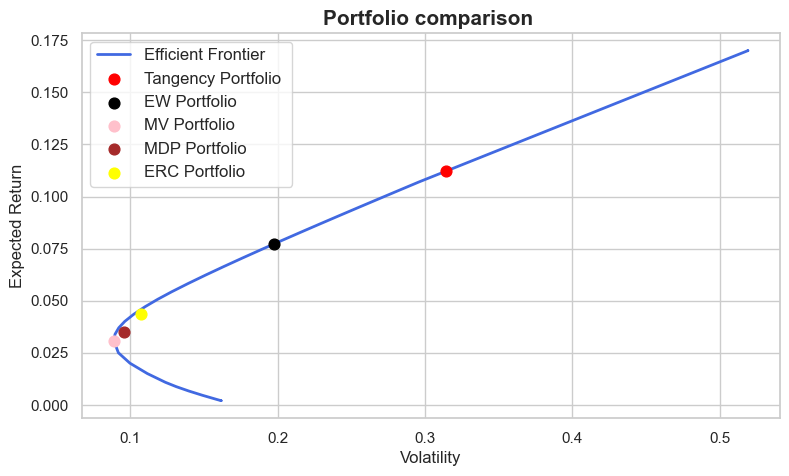

In [32]:
sns.set_theme(style="whitegrid") 
plt.figure(figsize=(9, 5))
plt.plot(gamma_volatilities_LongOnly, gamma_returns_LongOnly, color='royalblue', linewidth=2, label="Efficient Frontier", linestyle='-')
plt.title("Efficient Frontier LongOnly", fontsize=15, fontweight='bold')
plt.xlabel("Volatility (Sigma)", fontsize=12)
plt.ylabel("Expected Return (Mu)", fontsize=12)

plt.scatter(portfolio_vol(tangency_portfolio_Long_Only,covariance), portfolio_mean(tangency_portfolio_Long_Only,mus), color='red', s=60, zorder=3, label="Tangency Portfolio ")
plt.scatter(portfolio_vol(EW_Portfolio,covariance), portfolio_mean(EW_Portfolio,mus), color='black', s=60, zorder=3, label="EW Portfolio ")
plt.scatter(portfolio_vol(minimum_variance_portfolio,covariance), portfolio_mean(minimum_variance_portfolio,mus), color='pink', s=60, zorder=3, label="MV Portfolio ")
plt.scatter(portfolio_vol(MDP_portfolio,covariance), portfolio_mean(MDP_portfolio,mus), color='brown', s=60, zorder=3, label="MDP Portfolio ")
plt.scatter(portfolio_vol(ERC_Portfolio_CCD,covariance), portfolio_mean(ERC_Portfolio_CCD,mus), color='yellow', s=60, zorder=3, label="ERC Portfolio ")


plt.title("Portfolio comparison ", fontsize=15, fontweight='bold')
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)

plt.legend(fontsize=12)


plt.show()



4f

In [33]:
def beta_compute(p1,p2,covariance):
    return (p1.T@covariance@p2)/(p2.T@covariance@p2)

In [34]:
betas_tangency = {
    "MSR": beta_compute(tangency_portfolio_Long_Only, tangency_portfolio_Long_Only,covariance).squeeze(),
    "EW": beta_compute(EW_Portfolio, tangency_portfolio_Long_Only,covariance).squeeze(),
    "MV": beta_compute(minimum_variance_portfolio, tangency_portfolio_Long_Only,covariance).squeeze(),
    "MDP": beta_compute(MDP_portfolio, tangency_portfolio_Long_Only,covariance).squeeze(),
    "ERC": beta_compute(ERC_Portfolio_CCD, tangency_portfolio_Long_Only,covariance).squeeze()
}

betas_EW = {
    "MSR": beta_compute(tangency_portfolio_Long_Only, EW_Portfolio,covariance).squeeze(),
    "EW": beta_compute(EW_Portfolio, EW_Portfolio,covariance).squeeze(),
    "MV": beta_compute(minimum_variance_portfolio, EW_Portfolio,covariance).squeeze(),
    "MDP": beta_compute(MDP_portfolio, EW_Portfolio,covariance).squeeze(),
    "ERC": beta_compute(ERC_Portfolio_CCD, EW_Portfolio,covariance).squeeze()
}

print("=" * 50)
print(" Beta Values with Benchmark: Long-Only Tangency Portfolio (MSR) ")
print("=" * 50)
for portfolio, beta in betas_tangency.items():
    print(f" {portfolio} | Beta: {beta}")

print("\n" + "=" * 50)
print(" Beta Values with Benchmark: Equal-Weighted Portfolio (EW) ")
print("=" * 50)
for portfolio, beta in betas_EW.items():
    print(f" {portfolio} | Beta: {beta}")

print("\n" + "=" * 50)

 Beta Values with Benchmark: Long-Only Tangency Portfolio (MSR) 
 MSR | Beta: 1.0
 EW | Beta: 0.617988700855291
 MV | Beta: 0.12081048617288716
 MDP | Beta: 0.1643907907426409
 ERC | Beta: 0.25642240465311017

 Beta Values with Benchmark: Equal-Weighted Portfolio (EW) 
 MSR | Beta: 1.5659014402897846
 EW | Beta: 1.0
 MV | Beta: 0.2580625523587985
 MDP | Beta: 0.3262097936858171
 ERC | Beta: 0.46248926403463503

